In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, linear_model, cluster, \
    preprocessing, metrics, pipeline, tree, ensemble

%matplotlib inline

In [4]:
df = pd.read_csv("/data/iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
y = preprocessing.LabelEncoder().fit_transform(df.Species)

In [10]:
X = df.iloc[:, 1:-1]
X = preprocessing.StandardScaler().fit_transform(X)
pd.DataFrame(X).sample(10)

,0,1,2,3
47,-1.506521,0.337848,-1.341272,-1.312977
144,1.038005,0.569251,1.103953,1.710902
1,-1.143017,-0.124958,-1.341272,-1.312977
74,0.674501,-0.356361,0.307833,0.133226
62,0.189830,-1.976181,0.137236,-0.261193
88,-0.294842,-0.124958,0.194102,0.133226
51,0.674501,0.337848,0.421564,0.396172
16,-0.537178,1.957669,-1.398138,-1.050031
80,-0.416010,-1.513375,0.023504,-0.129720
102,1.522676,-0.124958,1.217684,1.185010


In [23]:
kmeans = cluster.KMeans(n_clusters=3)
y_cluster = kmeans.fit_predict(X)

In [25]:
metrics.homogeneity_score(y, y_cluster)

0.6591265018049008

In [24]:
kmeans.cluster_centers_

array([[-0.05021989, -0.88029181,  0.34753171,  0.28206327],
       [-1.01457897,  0.84230679, -1.30487835, -1.25512862],
       [ 1.13597027,  0.09659843,  0.996271  ,  1.01717187]])

In [29]:
pd.Series(y_cluster).value_counts()

0    53
1    50
2    47
dtype: int64

In [51]:
features_columns = df.iloc[:, 1:-1].columns

In [52]:
X_cluster = pd.DataFrame(X, columns=features_columns).copy()
X_cluster["cluster"] = y_cluster

def find_distance(r):
    p1 = r[:-1]
    cluster_index = int(r[-1])
    p2 = kmeans.cluster_centers_[cluster_index]
    return np.sqrt(np.sum((p1-p2) ** 2))

X_cluster["distances"] = X_cluster.apply(find_distance, axis = 1)

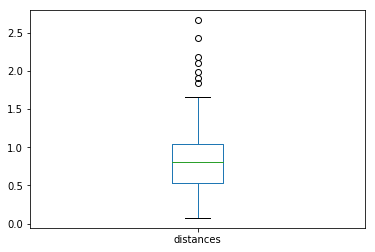

In [45]:
X_cluster.distances.plot.box()

In [89]:
outliers = X_cluster.sort_values("distances", ascending=False).iloc[:7, :]
outliers

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,cluster,distances
41,-1.627688,-1.744778,-1.398138,-1.181504,1,2.661396
15,-0.173674,3.114684,-1.284407,-1.050031,1,2.431728
131,2.492019,1.726266,1.502013,1.053537,2,2.179858
117,2.249683,1.726266,1.672610,1.316483,2,2.107889
60,-1.021849,-2.438987,-0.147093,-0.261193,0,1.978225
33,-0.416010,2.651878,-1.341272,-1.312977,1,1.907224
118,2.249683,-1.050569,1.786341,1.447956,2,1.834704


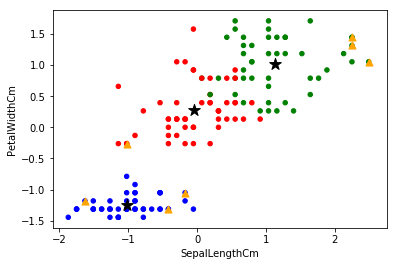

In [93]:
features = ["SepalLengthCm", "PetalWidthCm"]
fig, ax = plt.subplots()

color_dict = {0: "red", 1: "blue", 2: "green"}

cluster_colors = pd.Series(y_cluster).apply(lambda r: color_dict[r])

X_cluster.plot.scatter(features[0], features[1], ax = ax, color = cluster_colors)
outliers.plot.scatter(features[0], features[1], ax = ax, color = "orange", marker="^", s = 50)
pd.DataFrame(kmeans.cluster_centers_, columns=features_columns)\
    .plot.scatter(features[0], features[1], marker = "*", s = 150, ax = ax, color = "black")

# Reduce dimension using PCA

In [62]:
from sklearn import decomposition

In [63]:
pca = decomposition.PCA(n_components=None)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

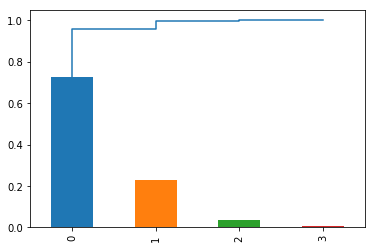

In [68]:
pd.Series(pca.explained_variance_ratio_).plot.bar()
plt.step(range(4), np.cumsum(pca.explained_variance_ratio_))

In [80]:
pca = decomposition.PCA(n_components=2)
X_pca = pd.DataFrame(pca.fit_transform(X))
X_pca["cluster"] = y_cluster

In [96]:
centroid_pca = pca.transform(kmeans.cluster_centers_)
outliers_pca = pd.DataFrame(pca.transform(outliers.iloc[:, :4].values))

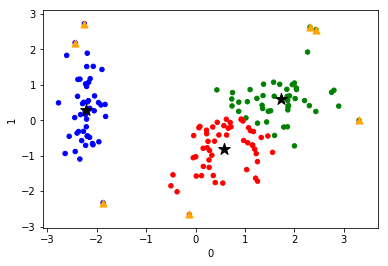

In [99]:
fig, ax = plt.subplots()
pd.DataFrame(X_pca).plot.scatter(0, 1, color = cluster_colors, ax = ax)
pd.DataFrame(centroid_pca).plot.scatter(0, 1, marker = "*", s= 150, ax = ax, color = "black")
outliers_pca.plot.scatter(0, 1,
                        ax = ax, color = "orange", marker="^", s = 50)
